In [93]:
from MNIST_dataloader import Noisy_MNIST
from Fast_MRI_dataloader import Fast_MRI
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data import TensorDataset
import glob
import numpy as np
from tqdm import tqdm 
from PIL import Image

In [69]:
# Bram
data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
#Amin
# data_loc = 'C://Gebruikers/amin2/Documenten/School/5LSL0 - MLSignal/5LSL0/data'

In [71]:
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders_noisy_mnist(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [112]:
def train_lista_denoise(noisy_image, gt_image, step_size, num_steps, lambda_vals, num_unfolds, num_epochs):
    # Define the denoising network
    denoiser = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 1, kernel_size=3, padding=1)
    )

    # Initialize a list to store the denoised images
    denoised_images = []

    # Scale the noisy and ground truth images to the range [0, 2] and shift them to the range [-1, 1]
    noisy_image = (noisy_image + 1) * 0.5
    gt_image = (gt_image + 1) * 0.5

    # Initialize the denoised image
    denoised_image = torch.zeros_like(noisy_image)

    # Define the lambda values as learnable parameters
    lambda_vals = nn.ParameterList([nn.Parameter(torch.tensor(lambda_val)) for lambda_val in lambda_vals])

    # Set up the optimizer to optimize the denoiser and lambda values
    optimizer = optim.Adam(list(denoiser.parameters()) + list(lambda_vals.parameters()), lr=0.01)

    # Loss function
    loss_fn = nn.MSELoss()

    # Track loss values
    loss_history = []

    # Training loop
    for epoch in range(num_epochs):
        # Perform ISTA denoising with multiple unfolds
        for unfold in range(num_unfolds):
            for i in range(num_steps):
                # Compute the gradient of the denoising network
                gradient = denoiser(denoised_image)

                # Compute the residual
                residual = noisy_image - gradient

                # Update the denoised image
                denoised_image = denoised_image + step_size * residual

                # Apply proximal operator (soft-thresholding)
                lambda_val = lambda_vals[i % len(lambda_vals)]  # Cycle through lambda values
                denoised_image = soft_threshold(denoised_image, lambda_val)

                # Optimize denoiser and lambda_val using L2 loss between denoised_image and ground truth image
                optimizer.zero_grad()
                loss = loss_fn(denoised_image, gt_image)

                # Backward pass with retain_graph=True
                loss.backward(retain_graph=True)

                # Detach the denoised image from the computation graph
                denoised_image = denoised_image.detach()

                # Store the denoised image at this epoch
                denoised_images.append(denoised_image)
                
                # Update the parameters using the gradients
                optimizer.step()

                # Clear gradients
                optimizer.zero_grad()

        # Store the loss value
        loss_history.append(loss.item())

        # Convert the list of denoised images to a tensor
        denoised_images = torch.stack(denoised_images)

        # Print loss at the end of each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

    # Plot the loss
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Scale the denoised image back to the range [-1, 1] and shift it to the range [0, 1]
    denoised_image = denoised_image * 2 - 1
    denoised_image = torch.clamp(denoised_image, 0, 1)

    # Convert the denoised image back to a numpy array
    denoised_image = denoised_image.squeeze().squeeze().detach().numpy()

    return denoised_image



def soft_threshold(x, threshold):
    result = x + 0.5 * (torch.sqrt((x - threshold) ** 2 + 1) - torch.sqrt((x + threshold) ** 2 + 1))
    return result

In [155]:
def train_lista_denoise(noisy_image, gt_image, step_size, num_steps, lambda_vals, num_unfolds, num_epochs):
    # Define the denoising network
    denoiser = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 1, kernel_size=3, padding=1)
    ).to(device)

    # Move the input tensors to the GPU device
    noisy_image = noisy_image.to(device)
    gt_image = gt_image.to(device)

    # Scale the noisy and ground truth images to the range [0, 2] and shift them to the range [-1, 1]
    noisy_image = (noisy_image + 1) * 0.5
    gt_image = (gt_image + 1) * 0.5

    # Initialize the denoised image
    denoised_image = torch.zeros_like(noisy_image).to(device)

    # Define the lambda values as learnable parameters
    lambda_vals = nn.ParameterList([nn.Parameter(torch.tensor(lambda_val).to(device)) for lambda_val in lambda_vals])

    # Set up the optimizer to optimize the denoiser and lambda values
    optimizer = optim.Adam(list(denoiser.parameters()) + list(lambda_vals.parameters()), lr=0.01)

    # Loss function
    loss_fn = nn.MSELoss()

    # Track loss values and denoised images
    loss_history = []
    denoised_images = []

    # Training loop
    for epoch in range(num_epochs):
        # Perform ISTA denoising with multiple unfolds
        for unfold in range(num_unfolds):
            for i in range(num_steps):
                # Compute the gradient of the denoising network
                gradient = denoiser(denoised_image)

                # Compute the residual
                residual = noisy_image - gradient

                # Update the denoised image
                denoised_image = denoised_image + step_size * residual

                # Apply proximal operator (soft-thresholding)
                lambda_val = lambda_vals[i % len(lambda_vals)]  # Cycle through lambda values
                denoised_image = soft_threshold(denoised_image, lambda_val)

                # Optimize denoiser and lambda_val using L2 loss between denoised_image and ground truth image
                optimizer.zero_grad()
                loss = loss_fn(denoised_image, gt_image)

                # Backward pass with retain_graph=True
                loss.backward(retain_graph=True)

                # Detach the denoised image from the computation graph
                denoised_image = denoised_image.detach()

                # Update the parameters using the gradients
                optimizer.step()

                # Clear gradients
                optimizer.zero_grad()

        # Store the loss value and denoised image
        loss_history.append(loss.item())
        denoised_images.append(denoised_image.clone().cpu())

        # Print loss at the end of each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

    # Plot the loss
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Convert the denoised images to numpy arrays
    denoised_images = [image.squeeze().squeeze().numpy() for image in denoised_images]

    return denoised_images

In [156]:
step_size = 0.00001
num_steps = 2000
lambda_vals = [0.4 ,0.4, 0.4]
num_unfolds = 3
num_epochs = 10

In [157]:
# get dataloader
batch_size = 32
train_loader, test_loader = create_dataloaders_noisy_mnist(data_loc, batch_size)
    
# get some examples
training_set = enumerate(train_loader)
_, (x_clean, x_noisy, labels) = next(training_set)

noisy_image = x_noisy
gt_image = x_clean

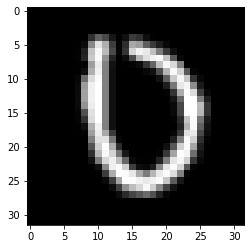

In [104]:
array = (x_clean)[0,:,:,:].squeeze()
array.size()

plt.imshow(array, cmap='gray')
plt.show()

In [158]:
denoised_images = train_lista_denoise(noisy_image, gt_image, step_size, num_steps, lambda_vals, num_unfolds, num_epochs)

KeyboardInterrupt: 

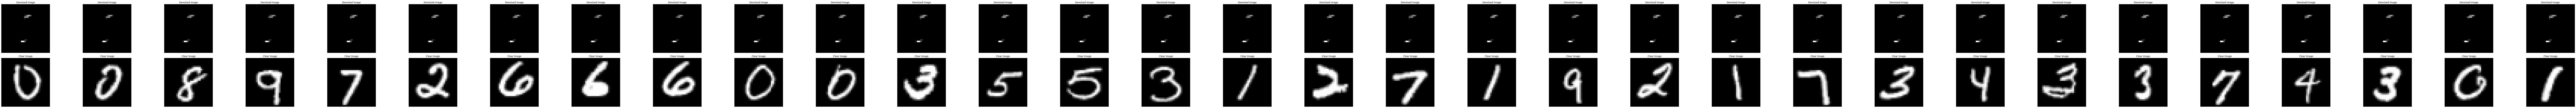

In [122]:
num_images = len(denoised_images)

 # Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(6 * num_images, 8))

for i in range(num_images):
#    # Get the clear image and denoised image for the current iteration
     denoised_image_np = denoised_images[i].squeeze()
     clear_image_np = gt_image[i].squeeze()
     

#     # Plot the denoised image in the first row of subplots
     axes[0, i].imshow(denoised_image_np, cmap='gray')
     axes[0, i].set_title('Denoised Image')
     axes[0, i].axis('off')  

#     # Plot the clear image in the second row of subplots
     axes[1, i].imshow(clear_image_np, cmap='gray')
     axes[1, i].set_title('Clear Image')
     axes[1, i].axis('off')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

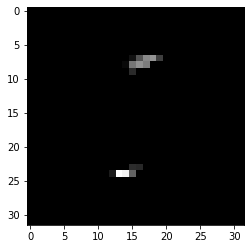

In [145]:
array = (denoised_images)[4,:,:].squeeze()


plt.imshow(array, cmap='gray')

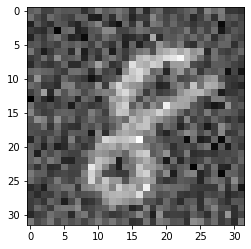

In [151]:
noisy_image
array = (noisy_image)[2,:,:,:].squeeze()


plt.imshow(array, cmap='gray')